35 min to run

In [1]:
import torch
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import random
import sys
sys.path.append("..")
from inference import GaussMarkovLagrange
from likelihoods import PointProcess
from mappings import AffineMapping
from transition import FixedPointSparseGP, SparseGP
from kernels import RBF
from linkfunctions import Exp
from models import PointProcessGPSDEmodel, GPSDE

In [2]:
print(torch.__version__) # double check that this is the version from requirements.txt

1.10.0+cpu


# Generate data

General functions

Van der Pol's oscillator function:
$ f_1(x)=\rho \tau \left( x_1 -\frac{1}{3}x_1^3-x_2 \right)=dx ,\quad f_2(x)=\frac{\tau}{\rho}x_1=dy$
can be used as a model for action potential of neurons 

$\tau$ is linked to the frequency of the oscillation, $\rho$ with amplitude, noise , relation btw x1,x2 of the sde
Just an example (could be another dynamical system that can be controled)


SDE : $ x_{i+1}=x_i + f(x_i) dt + \sqrt{\sigma dt } R $ 


Spikes: $h=x_{path}* C + d, \quad binSpike=poisson(\exp{(h)} *dt)$

h is approximately log(lambda) with lambda the mean and var of the poisson law $P(X=k)=\frac{\lambda^k}{k!}e^{-\lambda}$

In [3]:
#Vanderpol oscillator function 5.2 of paper : a is rho
def vanderpol(x, a, tau):
    """ Input : x (N,2) array (N number of samples)
                a, tau float corresponding to rho and tau
        Output : (N,2) array"""
    x1 = x[:,0]
    x2 = x[:,1]
    dx = a * (x1 - 1./3.*x1**3 - x2)
    dy = 1./a * x1
    return tau * np.array([dx, dy]).T

#correspond to eq (1) of paper (cont time latent sde model) in fact Euler
def simulate_sde(f, x0, tmax, dt, sigma=1.):
    """Input :  f function
                x0 initialisation point (1,2) array 
                tmax flot max time
                dt float time step size
                sigma ? 
        Output : (tmax/dt,2) array"""
    x = np.array(x0)
    N = int(tmax / dt) # number of steps
    for i in range(N - 1):
        x = np.append(x, x[i][None,:] + f(x[i][None,:]) * dt + np.sqrt(sigma * dt) * np.random.randn(1, max(x0.shape)),axis=0)
    return x

#Create spike from sde for neural pop dynamic 5.3 
def simulate_spikes_from_SDE(xpath, dt, C, d):
    """Input :  xpath (tmax/dt,2) array from simulate_sde
                dt float
                C (2,Num_Neurons) array
                d (1,Num_Neurons) array
       Output : binspike (tmax/dt,Num_Neurons) array for each time i neuron n draw a poisson rv with lambda=exp(h[i,n]dt)
                h (tmax/dt,Num_Neurons) intensity function (log(lambda) )"""
    # simulate Poisson spiking conditioned on discretised path of SDE
    h = np.matmul(xpath,C) + d # intensity function
    binSpike = np.random.poisson(np.exp(h) * dt) #expected number of spike in time bin dt
    return binSpike, h

#Conversion function to a list of time for eacch neuron
def binned_to_times(Ybin, tmax, dt):
    """Input :  Ybin (Num_Neurons, tmax/dt) correspond to binspike transpose !!
                tmax float
                dt float
        Ouput : list of two arrays : array i contain time at which neuron i was >0 in Ybin"""
    # convert binned simulated spike train to list of spike times for each neuron
    N = int(tmax / dt)
    yDim = Ybin.shape[0]
    tgrid = np.linspace(dt, tmax, N)
    Yspike = []
    for i in range(yDim):
        Yspike.append(tgrid[Ybin[i, :] > 0] + 1e-6 * np.random.randn(*np.shape(tgrid[Ybin[i, :] > 0]))) #noise too avoid 2 event at exactly the same time point

    return Yspike

#plot function 
def plotRaster(event_times_list, **kwargs):
    """ function to plot raster plot for a given trial"""
    ax = plt.gca() #get current axes
    for ith, trial in enumerate(event_times_list):
        plt.vlines(trial, ith + .5, ith + 1.5, **kwargs)
    plt.ylim(.5, len(event_times_list) + .5)
    plt.xlabel('Time')
    plt.ylabel('Neuron')
    return ax


# Try the functions

In [4]:
#Vanderpol
x=np.array([[1,1],[2,3],[4,5]])
tau=15
rho=2
vanderpol(x,rho,tau)

array([[ -10. ,    7.5],
       [-110. ,   15. ],
       [-670. ,   30. ]])

In [5]:
#spikes try
#np.random.seed(17489)
#sde function
x0 = np.random.randn(1, 2)
rho=2.
tau=15
func = lambda x: vanderpol(x, rho,tau)
tmax=0.1
dt = 0.01
xpath = simulate_sde(func, x0, tmax, dt, 1.5)

#spikes generation
yDim = 3 # number of neurons
C = 2.*np.random.rand(2,yDim) * np.random.choice([-1,1],size=(2,yDim)) #choice in [-2,2]
d = 0.1*np.random.randn(1,yDim)
ybin,h=simulate_spikes_from_SDE(xpath, dt, C, d)
print(ybin)
#print(h)
#there is a lot of 0 and few 1

#without dt
#h = np.matmul(xpath,C) + d # intensity function
#binSpike = np.random.poisson(np.exp(h) ) #to poission, why dt ?
#print(h)
#print(binSpike)
#a lot of differents values

#Conversion function
yspike=binned_to_times(ybin.T,tmax,dt)
print(yspike)


[[0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]]
[array([], dtype=float64), array([], dtype=float64), array([], dtype=float64)]


# Generate

Generate the x corresponding to a sde from the Van der pols function

$ xpath[i,j]=x_j(t_i) $ for $t_i \in [0, tmax/dt]$

(1000, 2)


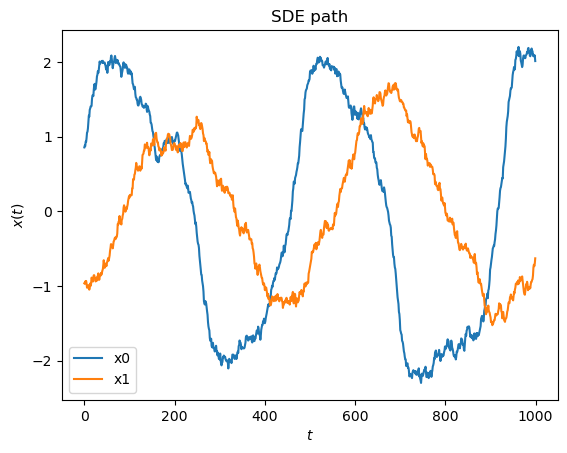

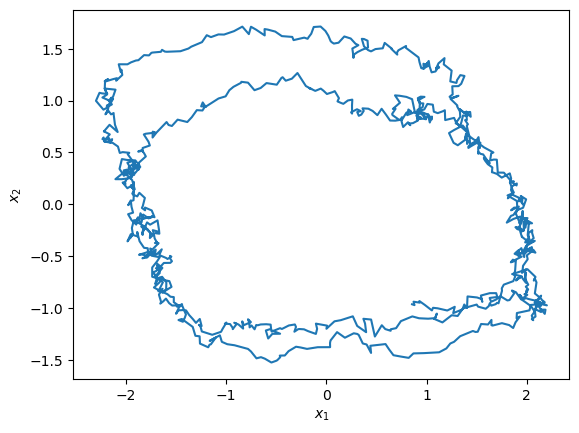

In [6]:
np.random.seed(17489)
# make a van der pols system with a stable limit cycle
x0 = np.random.randn(1, 2)
#tau = 15
#rho=2.
rho=2.
tau=15
func = lambda x: vanderpol(x, rho,tau)
#tmax = 1 (original)
tmax=1
dt = 0.001


xpath = simulate_sde(func, x0, tmax, dt, 1.5) # 1ms binning 
print(xpath.shape) 

#plot x in function of time
#plt.plot(xpath)
plt.plot(xpath[:,0],label='x0')
plt.plot(xpath[:,1],label='x1')
plt.legend()
plt.title('SDE path')
plt.ylabel('$x(t)$')
plt.xlabel('$t$')
plt.show()


plt.plot(xpath[:,0],xpath[:,1])
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')

plt.show()


Generate Neuron spike data 

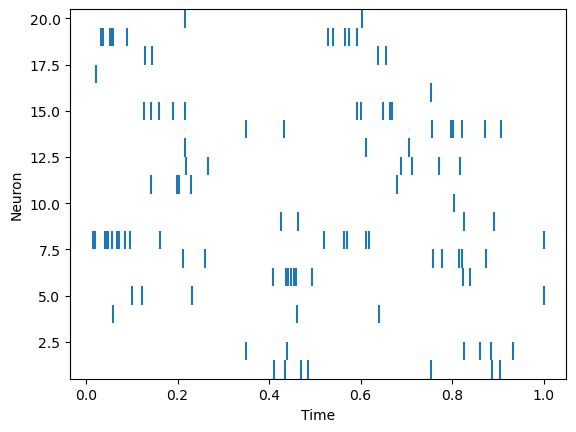

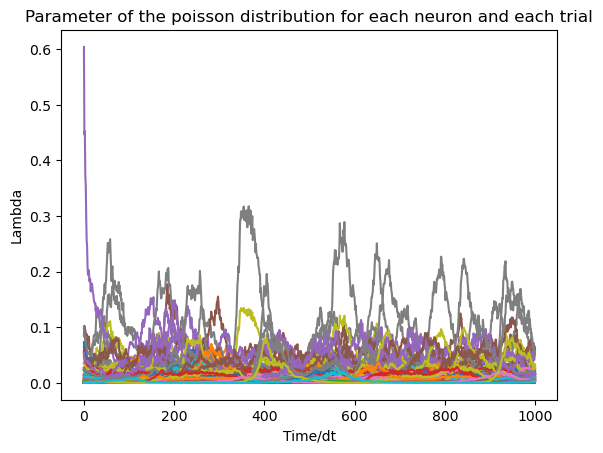

Number of spikes
110
112
97
123
113
154
87
109
110
116
120
98
115
101
96
138
110
113
107
99


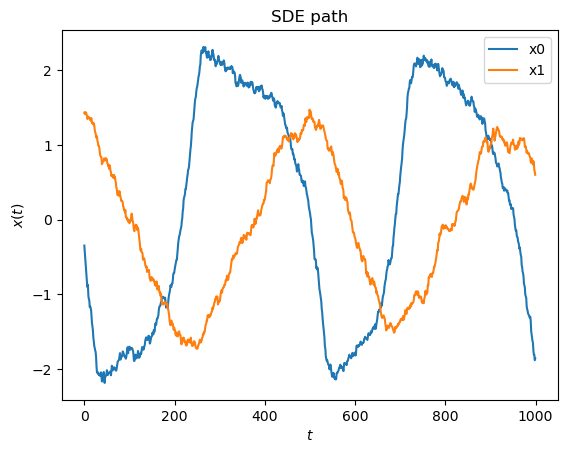

In [7]:
np.random.seed(101) #100 has a crazy lambda at 0 but a normal number of spike

#Parameters & initialisations
yDim = 20 # number of neurons
xDim = 2 #xpath dim
nTrials = 20 # number of trials
tmax = 1
trLen = tmax * np.ones(nTrials) # trial length (array of tmax)
C = 2.*np.random.rand(xDim,yDim) * np.random.choice([-1,1],size=(xDim,yDim)) #matrix of random in [-2,2] (not too big)
d = 0.1*np.random.randn(1,yDim)
xpath = []
Y = []
logRate = []

#Generate sde path and spike for every trials
#For every trial randomness in x0, poisson, random in sde
for n in range(nTrials): #Trials for different ini, why chosen like this bcs avoid big exp(h) in x0 (see graph below) maybe problem if too much
    if n < 10:
        x0 = np.sqrt(2)*np.random.randn(1,xDim) 
    else:
        x0 = np.zeros((1,xDim))

    xpath.append(simulate_sde(func, x0, trLen[n], 0.001, 1.)) # 1ms binning , sde for this trial
    Yn,logRaten = simulate_spikes_from_SDE(xpath[n], 0.001, C, d) #generate spikes for this trial
    Y.append(Yn)
    logRate.append(logRaten)

#Y is a list of lenght nTrials, each element an array of shape (tmax/dt,yDim)

#Yspike List by trial of a list by Neuron of array of spike time
#Yspike[i]=>List of Neuron for trial i, Yspike[i][j]=>Array of spike time for neuron j in trial i
Yspike= [binned_to_times(Y[n].T,trLen[n],0.001) for n in range(nTrials)]

#plots and prints 
Trial_to_see=1 #which trial we want to visualize

plotRaster(Yspike[Trial_to_see]) 
#plt.savefig('Raster_demo.pdf')
plt.show()

# look at firing rates and spike counts to make sure there aren't a crazy number of spikes due to exponential
for r in range(nTrials):
    plt.plot(np.exp(logRate[r])*dt,label='Trial '+str(r)) # correspond to the lambda of the poisson function for each neuron
plt.xlabel('Time/dt')
plt.ylabel('Lambda')
plt.title('Parameter of the poisson distribution for each neuron and each trial')
plt.show()

print("Number of spikes")
for r in range(nTrials):
    totSpikes = [len(Yspike[r][i]) for i in range(yDim)]
    #print(totSpikes)
    print(sum(totSpikes))


#plt.plot(xpath[1])
plt.plot(xpath[Trial_to_see][:,0],label='x0')
plt.plot(xpath[Trial_to_see][:,1],label='x1')
plt.legend()
plt.title('SDE path')
plt.ylabel('$x(t)$')
plt.xlabel('$t$')
plt.show()


# Modelling

+info double well

In [8]:
dtgrid = 0.004 # discretisation for solving ODEs
xDim = 2 # two latents

# pick model components:
link = Exp() # exponential link function (to define likelihood but whatfor ?)
like = PointProcess(Yspike, link, trLen, dtstep=dtgrid, nLeg=100) # point process likelihood 
outputMapping = AffineMapping(torch.tensor(C), torch.tensor(d)) # affine output mapping 
kern = RBF(xDim) # RBF kernel

# generater inducing point locations on a 2D grid (for sparse gp)
xmin, xmax = -2., 2.
Zs1, Zs2 = torch.meshgrid([torch.linspace(xmin,xmax,5), torch.linspace(xmin,xmax,5)])
numZ = 25
Zs = torch.cat((Zs1.reshape(-1,1),Zs2.reshape(-1,1)),dim=1)

# generater inducing point locations on a 2D grid (??why a second time ??)
#xmin, xmax = -2, 2
#Zs1, Zs2 = torch.meshgrid([torch.linspace(xmin,xmax,5), torch.linspace(xmin,xmax,5)])
#numZ = 25
#Zs = torch.cat((Zs1.reshape(-1,1),Zs2.reshape(-1,1)),dim=1)

transfunc = SparseGP(kern, Zs) # choose sparse GP as a transition function
transfunc.q_mu.data = torch.randn(transfunc.q_mu.size()).type(torch.float64) # random initialisation for inducing point posterior mean

# uncomment to instead condition on fixed points
#Zs_fx = torch.tensor([0., 0.]).view(-1,xDim)
# transition function conditioned on fixed point
#transfunc = SparseGP(kern, Zs, Zs_fx) 


# build point procces generative model for continuous time spike-time observations
model = PointProcessGPSDEmodel(xDim, transfunc, outputMapping, like, nLeg=100)

# assemble inference algorithm
inference = GaussMarkovLagrange(xDim, trLen, learningRate=1, dtstep=dtgrid)

# create GPSDE model object (final object)
myGPSDE = GPSDE(model, inference)

# fix inducing points on chosen grid
myGPSDE.model.transfunc.Zs.requires_grad = False


d:\logiciel\miniconda\lib\site-packages\torch\functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ..\aten\src\ATen\native\TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [9]:
# run EM (increase number of iterations for better results) (long to run )
myGPSDE.variationalEM(niter=30,eStepIter=10, mStepIter=10)

c:\Users\fosmo\OneDrive\Documents\GitHub\gpsde\demos\..\kernels.py:321: UserWarning: torch.solve is deprecated in favor of torch.linalg.solveand will be removed in a future PyTorch release.
torch.linalg.solve has its arguments reversed and does not return the LU factorization.
To get the LU factorization see torch.lu, which can be used with torch.lu_solve or torch.lu_unpack.
X = torch.solve(B, A).solution
should be replaced with
X = torch.linalg.solve(A, B) (Triggered internally at  ..\aten\src\ATen\native\BatchLinearAlgebra.cpp:766.)
  scaled_diffs, _ = torch.solve(mu_x2_new_diffs.transpose(-1, -2), lengthscales_new_squared.unsqueeze(-3))


-------------------------------------------------------
iter   objective    log-like      kl-div     f-prior
-------------------------------------------------------
   0   -2656.684    3597.658     887.263     -53.710
   1   -3215.102    3792.271     460.978    -116.191
   2   -3415.176    3992.681     420.451    -157.053
   3   -3485.700    4084.121     432.345    -166.076
   4   -3524.562    4121.694     432.878    -164.254
   5   -3551.029    4141.701     430.762    -159.910
   6   -3569.368    4154.333     429.369    -155.595
   7   -3582.625    4162.715     429.124    -150.966
   8   -3592.209    4168.259     429.433    -146.616
   9   -3598.989    4171.803     430.066    -142.748
  10   -3603.642    4174.029     430.875    -139.511
  11   -3606.846    4175.499     432.075    -136.578
  12   -3608.917    4176.417     433.489    -134.010
  13   -3610.084    4176.902     435.714    -131.104
  14   -3610.633    4176.859     437.262    -128.965
  15   -3610.614    4176.598     439.111

# Test and compare the model

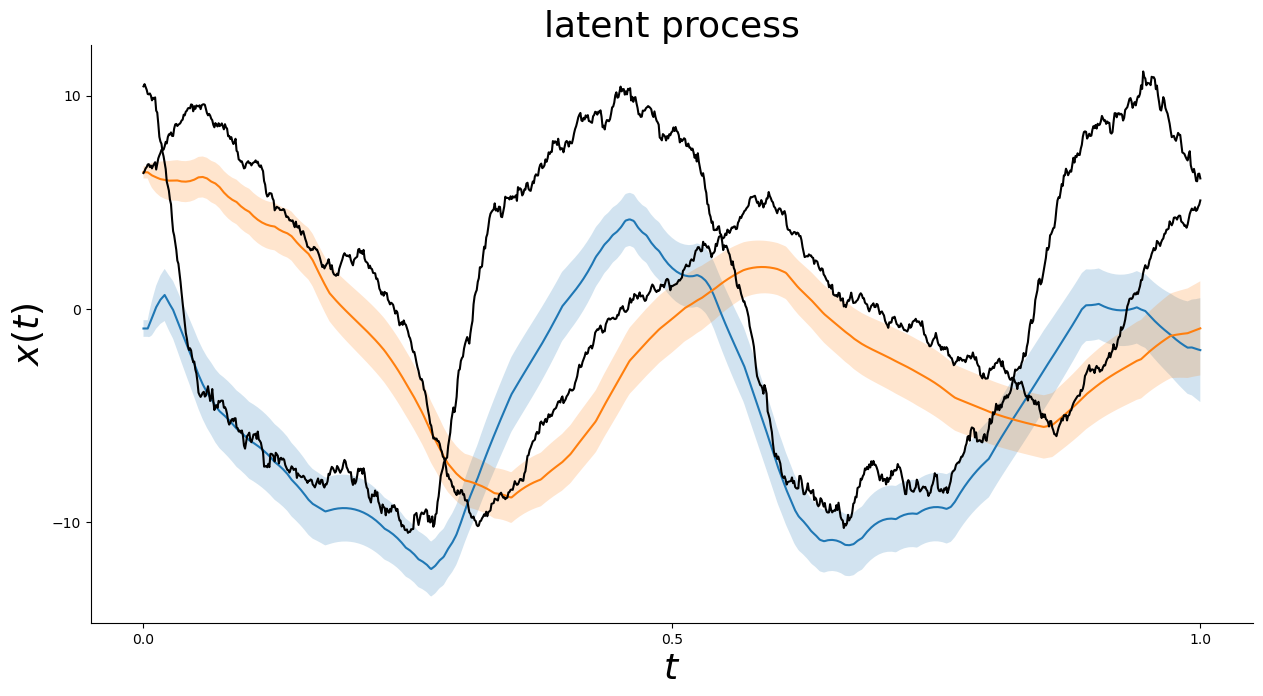

In [10]:
# evaluate trial
idx = 2
testTimes = torch.linspace(0,trLen[idx],int(trLen[idx]/0.001))

m, S = myGPSDE.inference.predict_marginals(idx, testTimes)
mr, Sr, Corth = myGPSDE.model.outputMapping.orthogonaliseLatents(m,S)


# plot the latent path and data in orthogonalised subspace
f, ax = plt.subplots()
f.set_figheight(7.5)
f.set_figwidth(15)
for i in range(xDim):
#     ax.plot(testTimes.numpy(),xpath[idx],color='black',linewidth=0.5,label='x(t)')
    ax.plot(testTimes.numpy(),mr[:,0,i].detach().squeeze().numpy(), label='$m_x(t)$')
    ax.fill_between(testTimes.numpy(), mr[:,0,i].detach().numpy()+np.sqrt(Sr[:,i,i].detach().numpy()), 
                mr[:,0,i].detach().squeeze().numpy()-np.sqrt(Sr[:,i,i].detach().numpy()), alpha=0.2)

    
Latents = Corth.detach().numpy().T @ (np.stack(logRate[idx] - d).T) # data projected into same subspace as inferred latents
plt.plot(np.linspace(0,trLen[idx],int(trLen[idx]/0.001)),Latents[0,:],color='black')
plt.plot(np.linspace(0,trLen[idx],int(trLen[idx]/0.001)),Latents[1,:],color='black')

# plot where observatioins lie
ax.locator_params(nbins=4)
ax.set_ylabel('$x(t)$',fontsize=26)
ax.set_xlabel('$t$',fontsize=26)
ax.set_title('latent process',fontsize=26)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.savefig("Latent_demo.pdf")
plt.show()

In [11]:
# visualise learned transition function and true transition function
ngrid = 20
xmin = -2.5
xmax = 2.5
x = torch.linspace(xmin,xmax,ngrid)
y = torch.linspace(xmin,xmax,ngrid)

xv, yv = torch.meshgrid([x, y])
xygrid = torch.cat((yv.reshape(-1, 1),xv.reshape(-1, 1)),dim=1)
out_est = myGPSDE.model.transfunc.predict(xygrid.unsqueeze(0))
out_true = func(np.concatenate((yv.numpy().reshape(-1, 1),xv.numpy().reshape(-1, 1)),axis=1))


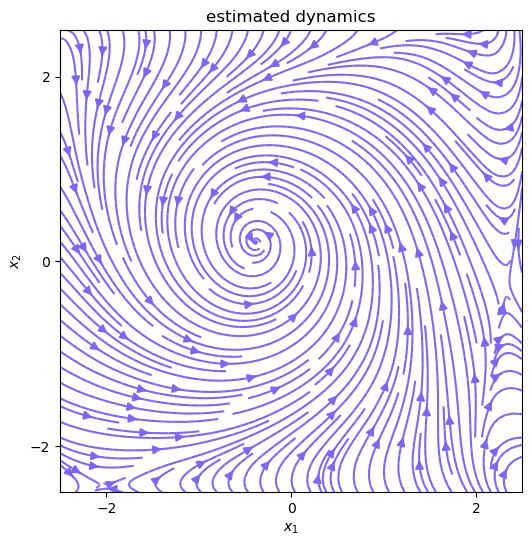

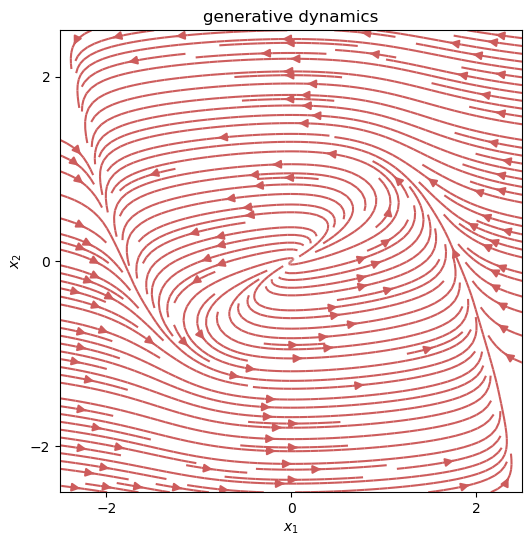

In [12]:

# visualise dynamics
sz = 6
plt.figure(figsize=(sz,sz))

plt.streamplot(x.numpy(), y.numpy(), out_est[0,:,0].detach().reshape(ngrid,ngrid).numpy(), 
           out_est[0,:,1].detach().numpy().reshape(ngrid, ngrid), arrowsize=1.2, 
                  density=2, color='mediumslateblue')

        
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.title('estimated dynamics')
plt.axis('square')
plt.locator_params(nbins=3)
plt.savefig("estimated_dyn_demo.pdf")
plt.show()

plt.figure(figsize=(sz,sz))
plt.streamplot(x.numpy(), y.numpy(), out_true[:,0].reshape(ngrid,ngrid), out_true[:,1].reshape(ngrid, ngrid), arrowsize=1.2, 
                  density=2, color='indianred')
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.title('generative dynamics')
plt.axis('square')
plt.locator_params(nbins=3)
plt.savefig("generative_dyn_demo.pdf")
plt.show()